<h1>Appendix<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-the-necessary-libraries" data-toc-modified-id="Importing-the-necessary-libraries-1">Importing the necessary libraries</a></span></li><li><span><a href="#Reading-the-datasets" data-toc-modified-id="Reading-the-datasets-2">Reading the datasets</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3">Exploratory Data Analysis</a></span></li><li><span><a href="#Integrating-the-train-and-store-datasets" data-toc-modified-id="Integrating-the-train-and-store-datasets-4">Integrating the train and store datasets</a></span></li><li><span><a href="#Conclusions-of-EDA" data-toc-modified-id="Conclusions-of-EDA-5">Conclusions of EDA</a></span></li><li><span><a href="#Creating-Outlier-Column-based-on-mean-absolute-deviation." data-toc-modified-id="Creating-Outlier-Column-based-on-mean-absolute-deviation.-6">Creating Outlier Column based on mean absolute deviation.</a></span></li><li><span><a href="#Holidays-this-week,-last-week-and-next-week." data-toc-modified-id="Holidays-this-week,-last-week-and-next-week.-7">Holidays this week, last week and next week.</a></span></li></ul></div>

#### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import json
# import lightgbm as lgb

from pandas import datetime
import math
import re
import time
import random
import os
import pickle
import joblib

from pandas.tseries.offsets import *
from operator import *

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

from IPython.display import Image

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

<ipython-input-1-d3132489bda7>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def annotate_plot(ax, attribute):
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black',
                xytext=(0, 10), textcoords='offset points')
    ax.axis(ymin=0,ymax=(train[attribute].mean() + (train[attribute].mean()*0.3)))

#### Reading the datasets

In [3]:
train = pd.read_csv('./Data_Preprocessing_Report/Data/Original/train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%d/%m/%Y')))

test = pd.read_csv('./Data_Preprocessing_Report/Data/Original/test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%d/%m/%Y')))

store = pd.read_csv('./Data_Preprocessing_Report/Data/Original/store.csv')

First few rows of the training set

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Let's take a look at the stucture of the training set

In [5]:
print("The number of rows and columns in the training set are: {} \n".format(train.shape))
train.info()

The number of rows and columns in the training set are: (1017209, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


There a over a million records in the traning set. This is a fair amount of data to perform forecast related data analytics

First few rows of the test set

In [6]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,NaN,NaN,1.0,1,0,0
1,3,4,2015-09-17,NaN,NaN,1.0,1,0,0
2,7,4,2015-09-17,NaN,NaN,1.0,1,0,0
3,8,4,2015-09-17,NaN,NaN,1.0,1,0,0
4,9,4,2015-09-17,NaN,NaN,1.0,1,0,0


The structure of the test set

In [7]:
print("The number of rows and columns in the test set are: {} \n".format(test.shape))
test.info()

The number of rows and columns in the test set are: (41088, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          41088 non-null  int64         
 1   DayOfWeek      41088 non-null  int64         
 2   Date           41088 non-null  datetime64[ns]
 3   Sales          0 non-null      float64       
 4   Customers      0 non-null      float64       
 5   Open           41077 non-null  float64       
 6   Promo          41088 non-null  int64         
 7   StateHoliday   41088 non-null  object        
 8   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 2.8+ MB


There are a littl over 41k records in the test set. One thing to note here is that the number of attributes in both the test and the train sets are the same but the arrtributes 'Sales' and 'Customers' in the test set are all blank

First 5 records of the store dataset

In [44]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print("The number of rows and columns in the store dataset are: {} \n".format(store.shape))
store.info()

The number of rows and columns in the store dataset are: (1115, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


As mentioned in the specification document, there are exactly 1115 different store captured in this data set. Although the store dataset is useless only it own, it might be helpful to integrate it with the training set to make our inputs to the model more robust. 

I have been told that the accuracy of the model is as good as the data that goes into it. Garbage-in-garbage-out.

#### Exploratory Data Analysis

Text(0.5, 1.0, 'A snapshot of how many stores are open/closed on each day of the week')

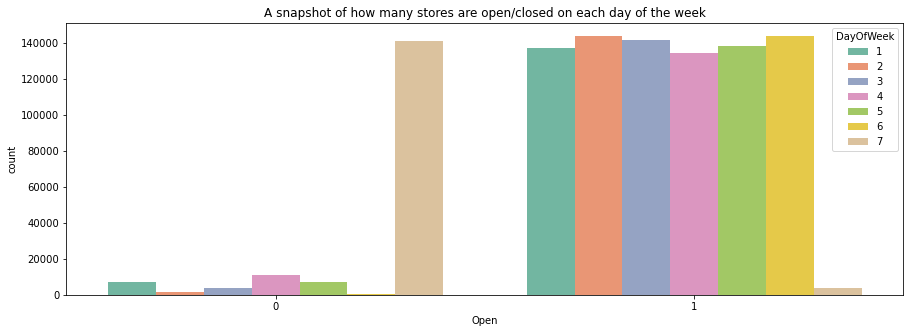

In [10]:
plt.subplots(figsize=(15,5))
sns.countplot(data=train, x='Open', hue='DayOfWeek', palette="Set2")
plt.title("A snapshot of how many stores are open/closed on each day of the week")

Here we can see that most stores are closed on Sundays. This may a trivial detail but this might help us in gaining insights and deduce information about those small number of store that are indeed open on Sundays

Text(0.5, 1.0, 'Average sales for each day of the week')

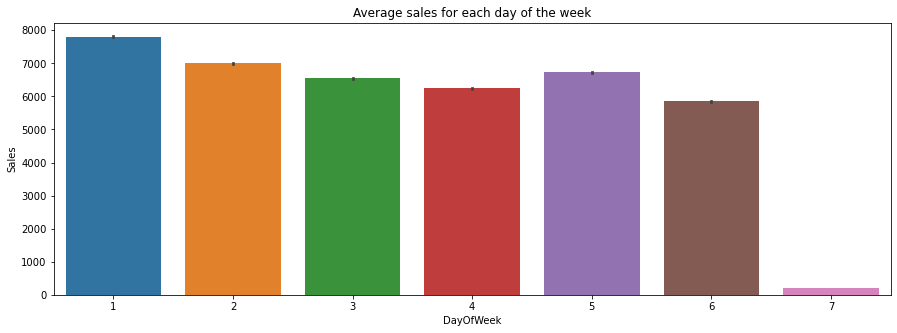

In [11]:
plt.subplots(figsize=(15,5))
sns.barplot(data=train, x='DayOfWeek', y='Sales', order=[1,2,3,4,5,6,7])
plt.title("Average sales for each day of the week")

The plots above depicts the overall sales for each day of the week. It is evident that the sales are lowest on Sundays and highest on Mondays. One major reason for the low sales on Sundays is the fact that most stores are closed on that day. And the reason why Monday witnesses the most sales might be because it follows right after Sunday and/or because it's the first day of the week. Many people visit pharmacies as part of their weekly chores/grocery shopping.

Text(0.5, 1.0, 'Average sales with and without a promotion')

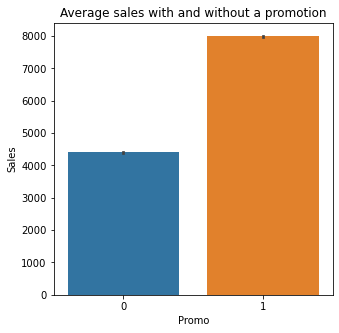

In [12]:
plt.subplots(figsize=(5,5))
sns.barplot(data=train, x='Promo', y='Sales')
plt.title("Average sales with and without a promotion")

It's quite obvious that the sales during a promotion will be higher than during the absence of a promotion, but what's important to note here is the fact that the sales almost double during promotion times. With this in mind, the store managers can double the their stock and man-power during promotions for frictionless management.

Text(0.5, 1.0, 'Average sales across each of the state holidays')

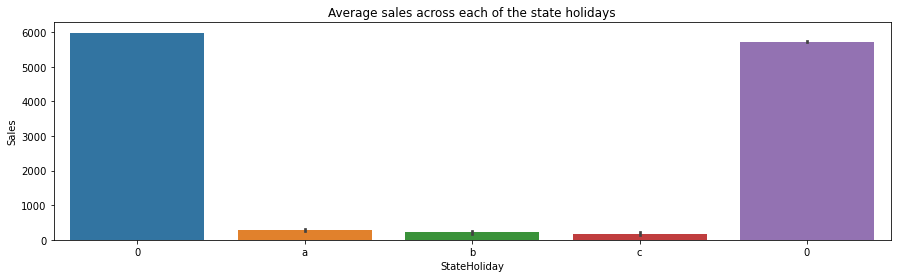

In [13]:
plt.subplots(figsize=(15,4))
ax = sns.barplot(data=train, x='StateHoliday', y='Sales')
plt.title("Average sales across each of the state holidays")
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    size=15,
#                    xytext = (0, -12), 
#                    textcoords = 'offset points')

In [14]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The plot of sales against State Holidays reveals 3 things: 

    1. There are 2 types of 0 values in the dataset. One being a string and another being an int value.
    2. Sales on all the three types of holidays (public holiday, Easter, and Christmas) is almost the same.
    3. Sales during non-holidays are significantly more than during holidays
    
Based on this observation and as a way to clean up this inconsistency in the data, we can combine the entries with both 0 values (int and string) into one and also combine the entries of all 3 store types into one. This way we can visualize the sales data on State Holidays as a whole

For this, I have introduced a new feature called "StateHoliday_combined" with 2 possible values, 0 = No state holiday and 1 = Some state holiday. We can later chose to drop on of the 2 state holiday columns depending on which one is more relevant

In [15]:
# Combine entires related to both 0's (int and string) into one
# Combine entries related to all 3 types of stores (a, b, and c) into one
train["StateHoliday_combined"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

Text(0.5, 1.0, 'Average sales during school holidays')

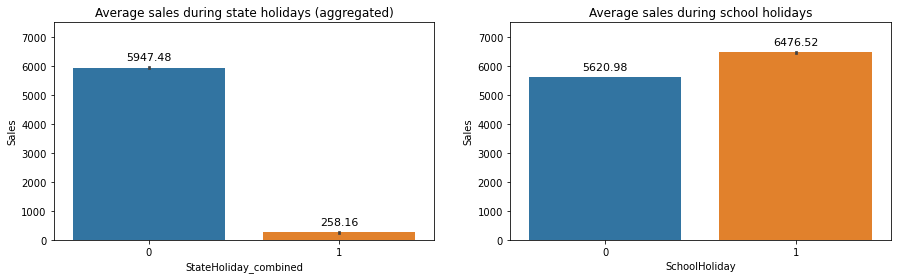

In [16]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

# ax1 = sns.countplot(x='StateHoliday_combined', data=train, ax=axis1)
ax1 = sns.barplot(x='StateHoliday_combined', y='Sales', data=train, ax=axis1)
ax1.ticklabel_format(style='plain', axis='y')
# ax1.axis(ymin=0,ymax=(train["Sales"].mean() + (train["Sales"].mean()*0.1)))
annotate_plot(ax1, "Sales")
ax1.set_title("Average sales during state holidays (aggregated)")

# ax2 = sns.countplot(x='SchoolHoliday', data=train, ax=axis2)
ax2 = sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis2)
ax2.ticklabel_format(style='plain', axis='y')
# ax2.axis(ymin=0,ymax=(train["Sales"].mean() + (train["Sales"].mean()*0.1)))
annotate_plot(ax2, "Sales")
plt.title("Average sales during school holidays")

Since most stores are closed during state holidays, it goes without says that sales during these holidays will significantly less. On the other hand, sales during school holidays are relatively higher compared to non-school holidays. Since there is no indication that the stores were closed during school holidays it is safe to assume that most stores were open during school holidays.

In [17]:
#Extracting some date features for analysis.
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

In [18]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_combined,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,0,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,0,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,0,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,0,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,2013,1,1,1


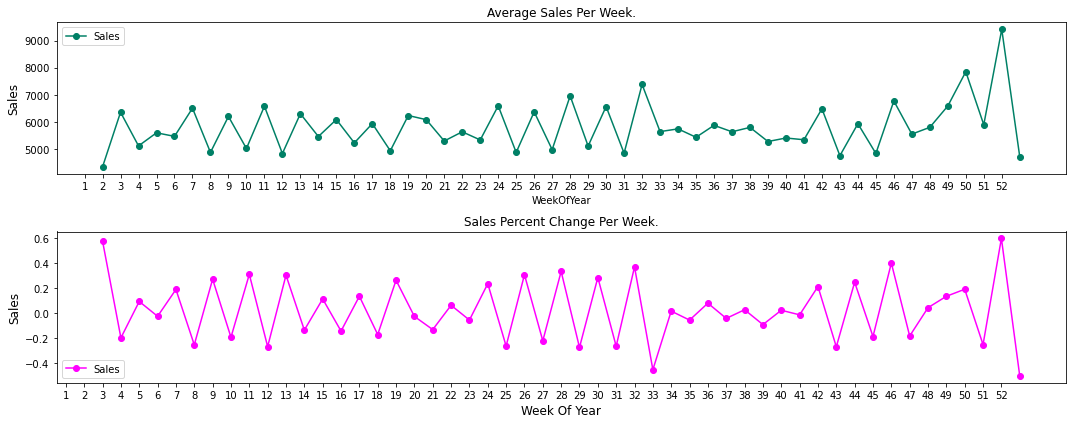

In [19]:
avg_sales    = train.groupby('WeekOfYear')["Sales"].mean()
percent_change_sales = train.groupby('WeekOfYear')["Sales"].sum().pct_change()
fig, (axis1,axis2) = plt.subplots(2, 1, figsize=(15,6))

ax1 = avg_sales.plot(legend=True, ax=axis1, marker='o', colormap="summer", 
                         title="Average Sales Per Week.")
ax1.set_xticks(range(len(avg_sales)))
ax1.set_xticklabels(avg_sales.index.tolist())
ax1.set_ylabel('Sales', size=12)

ax2 = percent_change_sales.plot(legend=True, ax=axis2, marker='o', colormap="spring", 
                            title="Sales Percent Change Per Week.")
ax2.set_xticks(range(len(avg_sales)))
ax2.set_xticklabels(avg_sales.index.tolist())
plt.ylabel("Sales", size=12)
plt.xlabel('Week Of Year', size=12)
fig.tight_layout()

The first insight that jumps out of the above plot is the, somewhat, obvious spike in sales during the last week of the week which also happens to be the week of Christmas/New Year. This spike may be due to the fact that people shop for gifts around this time and more often than not people tend indulge during the holiday season.

Text(0, 0.5, 'Promo counts')

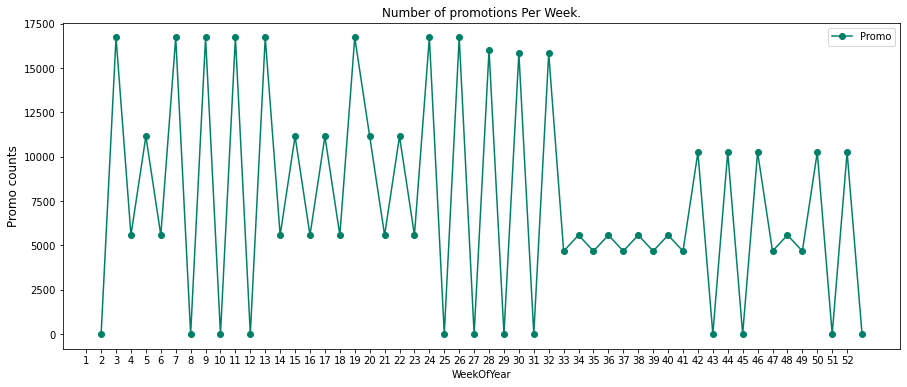

In [20]:
promo_counts = train.groupby('WeekOfYear')["Promo"].sum()

plt.subplots(figsize=(15,6))

ax1 = promo_counts.plot(legend=True, marker='o', colormap="summer", 
                         title="Number of promotions Per Week.")
ax1.set_xticks(range(len(promo_counts)))
ax1.set_xticklabels(promo_counts.index.tolist())
ax1.set_ylabel('Promo counts', size=12)

*** Revist this plot again to make sense of it

#### Integrating the train and store datasets

We combine the 2 datasets using the 'Store' attribute as the key.

In [21]:
s = store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
store = store.join(s)

In [22]:
combined_datasets = pd.merge(train, store, how='left', on='Store')
combined_datasets.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_combined,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,5,2015-07-31,5263,555,1,1,0,1,0,...,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,0,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
2,3,5,2015-07-31,8314,821,1,1,0,1,0,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,...,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,0,...,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
combined_datasets.shape

(1017209, 27)

After combining the datasets, we get a new dataset of 23 columns with the same number of records.

Text(0.5, 1.0, 'Average sales with and without an ongoing promotion (Promo2)')

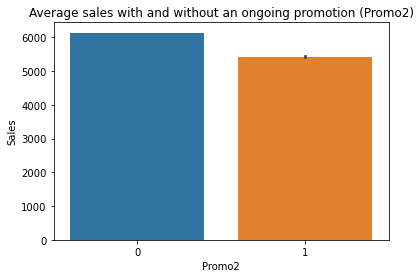

In [55]:
sns.barplot(combined_datasets['Promo2'], y=combined_datasets['Sales'])
plt.title("Average sales with and without an ongoing promotion (Promo2)")

The plot above reveals that the average sales for stores that did participate in Promo2 are higher than those store that didn't participate. Let's find out what is difference in revenue generated by stores with/without participating in Promo2

In [25]:
combined_datasets.groupby('Promo2')['StoreType'].count()

Promo2
0    508031
1    509178
Name: StoreType, dtype: int64

In [59]:
non_participating_store_sales_total = combined_datasets.loc[combined_datasets['Promo2']==0]['Sales'].sum()
participating_store_sales_total = combined_datasets.loc[combined_datasets['Promo2']==1]['Sales'].sum()
revenue_difference = non_participating_store_sales_total - participating_store_sales_total
print("The difference in the revenue generated by stores no Promo2 and sales with Promo2 is {}"
      .format(revenue_difference))

The difference in the revenue generated by stores no Promo2 and sales with Promo2 is 349904633


As you can, the difference between stores that particapted in Promo2 vs stores that didn't, is a whopping 349.90 million. It seems to be the case that stores that didn't participate in Promo2 were performing better even though the number of stores that participated in Promo2 is roughly equal to that of those that didn't participate. 

In [27]:
combined_datasets.groupby('StoreType')['Sales'].sum()

StoreType
a    3165334859
b     159231395
c     783221426
d    1765392943
Name: Sales, dtype: int64

In [28]:
combined_datasets.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


Between the output of the previous 2 cells, there is a lot of infomation. For instance, Store B has the least amount of total sales, but have the highest amount of average sales. What's even more interesting is that Store B has the least number of records present in the dataset. 

On the other hand, not only does Store A has the next best average sales (after store B), it also has the most number of records in the dataset and amount to the largest contributor sales with an overal revenue of over 3 billion dollars. 

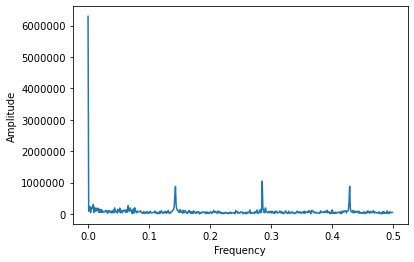

In [29]:
#Store Type 'A'.
df_store_11_sales = combined_datasets.loc[combined_datasets['Store']==11]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(df_store_11_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

A summary of the missing values in the dataset

In [30]:
print("Percentage of missing values in the combined dataset")
combined_datasets.isna().sum() * 100 / len(combined_datasets)

Percentage of missing values in the combined dataset


Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StateHoliday_combined         0.000000
Year                          0.000000
Month                         0.000000
Day                           0.000000
WeekOfYear                    0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
PromoInterval0               49.943620
PromoInterval1               49.943620
PromoInterval2           

In [43]:
print("Percentage of missing values in the test dataset")
test.isna().sum() * 100 / len(test)

Percentage of missing values in the test dataset


Store              0.000000
DayOfWeek          0.000000
Date               0.000000
Sales            100.000000
Customers        100.000000
Open               0.026772
Promo              0.000000
StateHoliday       0.000000
SchoolHoliday      0.000000
dtype: float64

It is important to note that most of the columns don't have any missing values, however, attributes related to competition and Promo2 have about 30% and 50% of the data missing. We need to find a way to meaningfully impute this data. 

In [50]:
train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()
store_duplicates = store.duplicated().sum()
print("The number of duplicate rows in train, test and store are ({}, {}, {}) respectively"
     .format(train_duplicates, test_duplicates, store_duplicates))

The number of duplicate rows in train, test and store are (0, 0, 0) respectively


In [60]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
def forward_selection(X, y, k_features)
    sfs = SFS(LinearRegression(),
              k_features=k_features,
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
    sfs.fit(X, y)
    return sfs.k_feature_names_

In [79]:
print(' List of features after perform feature extraction\n'
      ' using VIF and Forward Feature Selection:\n\n'
' Store\n',
'DayOfWeek\n',
'Promo\n',
'StateHoliday\n',
'SchoolHoliday\n',
'StoreType\n',
'Assortment\n',
'CompetitionDistance\n',
'CompetitionOpenSinceMonth\n',
'CompetitionOpenSinceYear\n',
'Promo2\n',
'Promo2SinceWeek\n',
'Promo2SinceYear\n',
'Year\n',
'Month\n',
'Day\n',
'WeekOfYear\n',
'DayOfYear\n',
'SalesPerDay\n',
'Customers_per_day\n',
'Sales_Per_Customers_Per_Day\n',
'PromoInterval0\n',
'PromoInterval1\n',
'PromoInterval2\n',
'PromoInterval3\n',
'Acceleration\n',
'State\n',
'Promo_before_days\n',
'Promo_after_days\n',
'Frequency_2\n',
'Frequency_3\n',
'Amplitude_2\n',
'Amplitude_3\n',
'Mean_TemperatureC\n',
'Events\n',
'Sales\n')

 List of features after perform feature extraction
 using VIF and Forward Feature Selection:

 Store
 DayOfWeek
 Promo
 StateHoliday
 SchoolHoliday
 StoreType
 Assortment
 CompetitionDistance
 CompetitionOpenSinceMonth
 CompetitionOpenSinceYear
 Promo2
 Promo2SinceWeek
 Promo2SinceYear
 Year
 Month
 Day
 WeekOfYear
 DayOfYear
 SalesPerDay
 Customers_per_day
 Sales_Per_Customers_Per_Day
 PromoInterval0
 PromoInterval1
 PromoInterval2
 PromoInterval3
 Acceleration
 State
 Promo_before_days
 Promo_after_days
 Frequency_2
 Frequency_3
 Amplitude_2
 Amplitude_3
 Mean_TemperatureC
 Events
 Sales



<AxesSubplot:xlabel='CompetitionOpenSinceYear', ylabel='Density'>

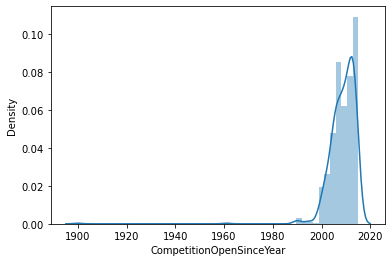

In [31]:
sns.distplot(store['CompetitionOpenSinceYear'])

In [32]:
year_median = store['CompetitionOpenSinceYear'].median()
print(f'Most of stores have their competition opened in the year {year_median}.')

Most of stores have their competition opened in the year 2010.0.


<AxesSubplot:xlabel='CompetitionOpenSinceMonth', ylabel='Density'>

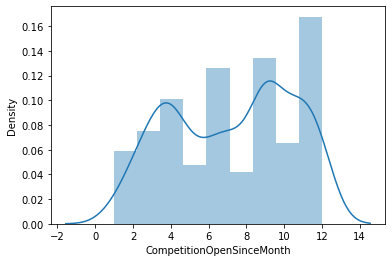

In [33]:
sns.distplot(store['CompetitionOpenSinceMonth'])

In [34]:
month_median = store['CompetitionOpenSinceMonth'].median()
print(f'Most of stores have their competition opened in the month {month_median}.')

Most of stores have their competition opened in the month 8.0.


In [35]:
store.loc[pd.isnull(store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",Feb,May,Aug,Nov


Text(0.5, 0, 'Competition Distance in meters')

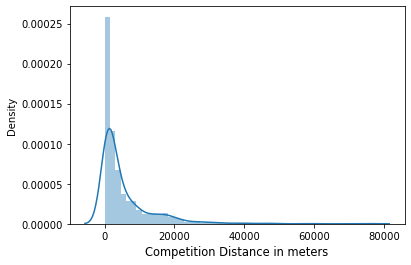

In [36]:
#Plotting distribution of Competition Distance.
sns.distplot(store['CompetitionDistance'])
plt.xlabel('Competition Distance in meters',fontsize=11.5)

In [37]:
distance_median = store['CompetitionDistance'].median()
print(f'Most of stores have their competition within {distance_median/1000}kms.')

Most of stores have their competition within 2.325kms.


Even though 31% of data is missing for CompetitionOpenSinceMonth and CompetitionOpenSinceYear, only 0.259% of the CompetitionDistance is missing. So the absence of competition month/year doesn't necessarily mean that there were no competitions around, it just means that we do not have info about when these rival were opened.  It goes without saying that distance and month/year values are not dependent on each other.

#### Conclusions of EDA

The most selling and crowded store type is A.

Sales is highly correlated to number of Customers.

For all stores, Promotion leads to increase in Sales and Customers both.

The stores which are opened during School Holiday have more sales than normal days.

More stores are opened during School holidays than State holidays.

Sales are increased during Chirstmas week, this might be due to the fact that people buy more beauty products during a Christmas celebration.

Absence of values in features CompetitionOpenSinceYear/Month doesn’t indicate the absence of competition as CompetitionDistance values are not null where the other two values are null.

After analysing sales using Fourier decomposition, I found that there’s a little seasonality component in the Sales data.

Data Transformation

Performing log transformation on the sales data

In [38]:
# combined_datasets['SalesLog'] = np.log1p(combined_datasets['Sales'])

In [39]:
# combined_datasets

#### Creating Outlier Column based on mean absolute deviation.

In [40]:
def mad_based_outlier(points, thresh=3.5):
    '''
    This function will calculate mean absolute deviation and return true or 
    false based on points which have MAD greater than threshold provided.
    '''
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [41]:
#Creating new column 'Outlier' which tells whether a point is outlier or not.
for i in combined_datasets['Store'].unique():
    combined_datasets.loc[(combined_datasets['Store'] == i) 
                          & (combined_datasets['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(combined_datasets.loc[(combined_datasets['Store'] == i) 
                                                & (combined_datasets['Open'] == 1)]['Sales'], 3.5)

KeyboardInterrupt: 

In [ ]:
combined_datasets['DayOfYear'] = combined_datasets['Date'].dt.dayofyear
combined_datasets['DayOfYear']

In [ ]:
combined_datasets.sort_values('Date', inplace=True)

#Removing all the outliers.
combined_datasets = combined_datasets.loc[combined_datasets['Outlier']==False].drop('Outlier', axis=1)

#### Holidays this week, last week and next week.

In [ ]:
# dict_for_store_holidays = dict()

In [ ]:
# for j in combined_datasets['Store'].unique():

#     a = combined_datasets.loc[combined_datasets['Store']==j]
#     a.sort_values(['Date'], inplace=True)

#     holidays_last_week, holidays_this_week, holidays_next_week = [], [], []
#     this_week_dict= dict()

#     for i in range(len(a)):

#         present_week = a.iloc[i]['WeekOfYear']
#         present_year = a.iloc[i]['Year']
        
#         df_present = a.loc[(a['WeekOfYear']==present_week) & (a['Year']==present_year) & (a['Open']==0)]

#         holidays = len(df_present)

#         if (present_year,present_week) not in this_week_dict.keys():
#             this_week_dict[(present_year,present_week)] = holidays
#         else:
#             continue
    
#     dict_for_store_holidays[j] = this_week_dict

In [ ]:
combined_datasets.info()

------------------------------------------------------------------------------------------------

In [ ]:
combined_datasets['StateHoliday'].replace(0, '0', inplace=True)

In [ ]:
# X = combined_datasets.drop(['SalesLog','Sales'], axis=1)
# y = combined_datasets['Sales']

In [ ]:
# Get total sales, customers and open days per store
store_data_sales = combined_datasets.groupby([combined_datasets['Store']])['Sales'].sum()
store_data_customers = combined_datasets.groupby([combined_datasets['Store']])['Customers'].sum()
store_data_open = combined_datasets.groupby([combined_datasets['Store']])['Open'].count()

In [ ]:
# Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [ ]:
#Saving the above values in a dictionary so that they can be mapped to the dataframe.
sales_per_day_dict = dict(store_data_sales_per_day)
customers_per_day_dict = dict(store_data_customers_per_day)
sales_per_customers_per_day_dict = dict(store_data_sales_per_customer_per_day)

In [ ]:
combined_datasets['SalesPerDay'] = combined_datasets['Store'].map(sales_per_day_dict)
combined_datasets['CustomersPerDay'] = combined_datasets['Store'].map(customers_per_day_dict)
combined_datasets['SalesPerCustomersPerDay'] = combined_datasets['Store'].map(sales_per_customers_per_day_dict)
combined_datasets

In [ ]:
combined_datasets

In [ ]:
# #Splitting PromoInterval into parts. For ex: (Jan,March,May) --> (Jan), (March), (May).
# s = combined_datasets['PromoInterval'].str.split(',').apply(pd.Series, 1)
# s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']

In [ ]:
# s

In [ ]:
# combined_datasets = combined_datasets.join(s, how='left', lsuffix='_left')
# combined_datasets

# s = df_SUBMIT['PromoInterval'].str.split(',').apply(pd.Series, 1)
# s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
# df_SUBMIT = df_SUBMIT.join(s)

In [ ]:
#Converting Promointerval columns to numerical.
month_to_num_dict = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sept' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12
#     ,
#                     'nan' : np.NaN
                    }

In [ ]:
month_to_num_dict

In [ ]:
combined_datasets['PromoInterval0'] = combined_datasets['PromoInterval0'].map(month_to_num_dict)
combined_datasets['PromoInterval1'] = combined_datasets['PromoInterval1'].map(month_to_num_dict)
combined_datasets['PromoInterval2'] = combined_datasets['PromoInterval2'].map(month_to_num_dict)
combined_datasets['PromoInterval3'] = combined_datasets['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature as no further use now.


In [ ]:
del combined_datasets['PromoInterval']

In [ ]:
combined_datasets

In [ ]:

base_X = combined_datasets[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']]

y = combined_datasets['Sales']

In [ ]:
cat_cols = ['StoreType','Assortment','StateHoliday','DayOfWeek','Promo','Year','Promo2', 'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
num_cols = [i for i in base_X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)])

In [ ]:
preprocessor.fit(base_X)
pickle.dump(preprocessor, open('./Data_Preprocessing_Report/Data/Original/preprocessor_base.pkl','wb'))

In [ ]:
preprocessor = pickle.load(open('./Data_Preprocessing_Report/Data/Original/preprocessor_base.pkl','rb'))

In [ ]:
X_transformed = preprocessor.transform(base_X)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, shuffle=False, random_state=21, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20,n_jobs=-1, random_state=21)
model.fit(X_train, y_train)

In [ ]:
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return "rmspe", rmspe

scorer = make_scorer(rmspe, greater_is_better=False)

In [ ]:
train_preds = model.predict(X_train)
rmspe(y_train,train_preds)

In [ ]:
preds = model.predict(X_test)
rmspe(y_test, preds)

In [ ]:
X_transformed 